# [NTDS'18] milestone 2: network models
[ntds'18]: https://github.com/mdeff/ntds_2018

[Hermina Petric Maretic](https://people.epfl.ch/hermina.petricmaretic), [EPFL LTS4](https://lts4.epfl.ch)

## Students

* Team: `<your team number>`
* Students: `<the name of all students in the team>`
* Dataset: `<the dataset you used to complete the milestone>`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* In the first part, you cannot import any other library than we imported. In the second part, you are allowed to import any library you want.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The purpose of this milestone is to explore various random network models, analyse their properties and compare them to your network. In the first part of the milestone you will implement two random graph models and try to fit them to your network. In this part you are not allowed to use any additional package. In the second part of the milestone you will choose a third random graph model that you think shares some properties with your network. You will be allowed to use additional packages to construct this network, but you must explain your network choice. Finally, make your code as clean as possible, and keep your textual answers short.

## Part 0

Import the adjacency matrix of your graph that you constructed in milestone 1, as well as the number of nodes and edges of your network.

In [47]:
import numpy as np

adjacency =  np.load('data/adjacency_sym_mtx_uw.npy')  # the adjacency matrix
n_nodes =  adjacency.shape[0] # the number of nodes in the network
adjacency[np.diag_indices_from(adjacency)] = 0 # set diagonal elements to 0 (see comment)
n_edges =  adjacency.sum() / 2 # the number of edges in the network

**Comment 1:** <br>
We have decided to import the symmetric unweighted adjacency matrix, previously computed in Milestone one. Why symmetric and unweighted ? <br>
Because in this milestone (2), we will compare our network to random network models. From the models we have seen in class, the random network models we will use and built by adding edges which are undirected and unweighted. Therefore we have concluded that it would make more sense to compare a network sharing the same properties, ie. the unweighted symmetric version of our network.

**Comment 2:** <br>
We have noticed that our previously constructed graph from Milestone 1, actually has self loop. It comes from the fact that, in the routes data set, one entry related an airport to itself : it is both the source and the destination airport of the entry (it is the airport having IATA _"PKN"_, and the entry at index 33276 in routes). As a consequence, our adjacency matrix has one non zero element on the diagonal. <br>
If we place this in the context of airlines, it doesn't really make sense to have a line from an airport to itself. We have therefore decided to ignore this edge in the adjacency matrix. This is why we compute the number of edges by summing the elements of the unweighted adjacency matrix and subtracting one. We divide by two since the matrix is symmetric : each path is represented twice for each direction.

## Part 1

**For the computation of this part of the milestone you are only allowed to use the packages that have been imported in the cell below.**

In [23]:
%matplotlib inline

import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

### Question 1

Create a function that constructs an Erdős–Rényi graph.

In [34]:
def erdos_renyi(n, p, seed=None):
    """Create an instance from the Erdos-Renyi graph model.
    
    Parameters
    ----------
    n: int
        Size of the graph.
    p: float
        Edge probability. A number between 0 and 1.
    seed: int (optional)
        Seed for the random number generator. To get reproducible results.
    
    Returns
    -------
    adjacency
        The adjacency matrix of a graph.
    """
    np.random.seed(seed)

    rnd = np.random.choice([0, 1], size=(n, n), p=[1-p, p])
    rnd = np.triu(rnd, 1)
    adjacency = rnd + rnd.T

    #adjacency = np.zeros((n, n))
    #for i in range(n):  # rows
    #    for j in range(n):  # cols
    #        if i > j:
    #            continue
    #        adjacency[i, j] = np.random.choice([0, 1], p=[1 - p, p])
    #        adjacency[j, i] = adjacency[i, j]
    
    return adjacency

0.32


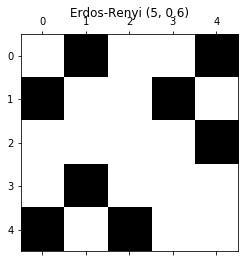

In [35]:
er = erdos_renyi(5, 0.6, 9765) #9765
plt.spy(er)
plt.title('Erdos-Renyi (5, 0.6)')

print(er.sum() / (5*5))

0.38


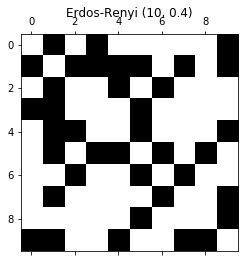

In [36]:
er = erdos_renyi(10, 0.4, 7648)
plt.spy(er)
plt.title('Erdos-Renyi (10, 0.4)')

print(er.sum() / (10*10))

### Question 2

Use the function to create a random Erdos-Renyi graph. Choose the parameters such that number of nodes is the same as in your graph, and the number of edges similar. You don't need to set the random seed. Comment on your choice of parameters.

In [38]:
er = erdos_renyi(n_nodes, 0.0037, None)
print('default no. of edges:', n_edges)
print('ER graph no. of edges:', er.sum() / 2)

default no. of edges: 18616.0
ER graph no. of edges: 18858.0


**Your answer here.**
We have set the parameter n to the number of nodes in our graph. Parameter p has been tuned so that the total number of edges is similar to our graph. In the end we have obtained parameters n=3179 and p=0.0037 which give us the number of edges around 18600 (in our graph 18616).

### Question 3

Create a function that constructs a Barabási-Albert graph.

In [39]:
def barabasi_albert(n, m, seed=None):
    """Create an instance from the Barabasi-Albert graph model.
    
    Parameters
    ----------
    n: int
        Size of the graph.
    m: int
        Number of edges to attach from a new node to existing nodes.
    seed: int (optional)
        Seed for the random number generator. To get reproducible results.
    
    Returns
    -------
    adjacency
        The adjacency matrix of a graph.
    """
    
    # Initialize number of nodes : must be at least the number of 
    # edges to attach from a new node to existing node
    n_nodes = m+1 
    np.random.seed(seed)
    
    # create full adjacency matrix (more efficient than adding nodes 
    # step by step)
    adj_graph = np.zeros((n,n))
    # create an initial complete graph
    for i in range(n_nodes) :
        for j in range(i) :
            adj_graph[i, j] = 1
                
    # keep table of degree of each node for preferential attachement
    degrees = np.ones(n_nodes) * m
    probas = np.ones(n_nodes)/n_nodes
    
    while n_nodes < n : 
        new_neighbours = np.random.choice(n_nodes, m, False, probas)
        adj_graph[n_nodes, new_neighbours] = 1
        
        # Update degrees and probas
        degrees = np.append(degrees, m)
        degrees[new_neighbours] += 1
        probas = degrees / np.sum(degrees)
        
        n_nodes += 1
        
    # symmetrize matrix
    return adj_graph + adj_graph.T

Text(0.5, 1.05, 'Barabasi-Albert (5, 1)')

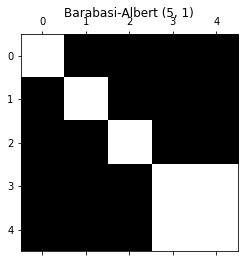

In [40]:
ba = barabasi_albert(5, 3, 9087)
plt.spy(ba)
plt.title('Barabasi-Albert (5, 1)')

Text(0.5, 1.05, 'Barabasi-Albert (10, 2)')

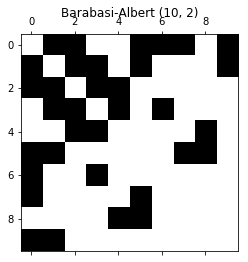

In [41]:
ba = barabasi_albert(10, 2, 8708)
plt.spy(ba)
plt.title('Barabasi-Albert (10, 2)')

### Question 4

Use the function to create a random Barabási-Albert graph. Choose the parameters such that number of nodes is the same as in your graph, and the number of edges similar. You don't need to set the random seed. Comment on your choice of parameters.

In [42]:
# Your code here.

**Your answer here**

### Question 5

Compare the number of edges in all three networks (your real network, the Erdős–Rényi network, and the Barabási-Albert netowk).

In [ ]:
# Your code here.

### Question 6

Implement a function that computes the [Kullback–Leibler (KL) divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between two probability distributions.
We'll use it to compare the degree distributions of networks.

In [43]:
def kl_divergence(p, q):
    """Compute the KL divergence between probability distributions of degrees of two networks.
    
    Parameters
    ----------
    p: np.array
        Probability distribution of degrees of the 1st graph.
    q: np.array
        Probability distribution of degrees of the 2nd graph.
    
    Returns
    -------
    kl
        The KL divergence between the two distributions.
    """
    
    kl = np.sum(p * np.log(p / q), axis=0)
    
    return kl

In [46]:
p_test = np.array([0.2, 0.2, 0.2, 0.4])
q_test = np.array([0.3, 0.3, 0.1, 0.3])
kl_divergence(p_test, q_test)

0.09151622184943575

### Question 7

Compare the degree distribution of your network to each of the two synthetic ones, in terms of KL divergence. **Hint:** Make sure you normalise your degree distributions to make them valid probability distributions.

In [ ]:
# Your code here.

### Question 8

Plot the degree distribution historgrams for all three networks. Are they consistent with the KL divergence results? Explain.

In [ ]:
# Your code here.

**Your answer here.**

### Question 9

Imagine you got equal degree distributions. Would that guarantee you got the same graph? Explain.

**Your answer here.**

## Part 2

**You are allowed to use any additional library here (e.g., NetworkX, PyGSP, etc.).** Be careful not to include something here and use it in part 1!

### Question 10

Choose a random network model that fits you network well. Explain your choice. 

**Hint:** Check lecture notes for different network models and their properties. Your choice should be made based on at least one property you'd expect to be similar.

**Your answer here.**

### Question 11

Explain (in short) how the chosen model works.

**Your answer here.**

### Question 12

Create a random graph from that model, such that the number of nodes is the same as in your graph.

In [ ]:
# Your code here.

### Question 13

Check the properties you expected to be similar, and compare to your network.

In [ ]:
# Your code here.

Are the results what you expected? Explain.

**Your answer here.**